# Generating Handwritten Digits with DCGAN

Most codes are from https://github.com/tensorflow/tensorflow/blob/r1.13/tensorflow/contrib/eager/python/examples/generative_examples/dcgan.ipynb

In [2]:
import imageio
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Dropout, Flatten, Reshape

from IPython import display

print(tf.__version__)
print(keras.__version__)

1.13.1
2.2.4-tf


In [3]:
tf.enable_eager_execution()

## Hyper Parameters

In [4]:
learning_rate = 0.0001
batch_size = 256
buffer_size = 60000
num_epochs = 70
noise_dim = 100
num_examples_to_generate = 16

## Preparing Data

In [5]:
(train_images, train_labels), (_, _) = keras.datasets.mnist.load_data()

In [6]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

## Making a Models

### Generator

In [8]:
def make_generator_model():
    model = keras.Sequential()
    model.add(Dense(1024, use_bias=False, input_shape=(noise_dim,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dense(7*7*256, use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
      
    model.add(Reshape((7, 7, 256)))  
    
    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))    
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))    
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))    
  
    return model

### Discriminator

In [9]:
def make_discriminator_model():
    model = keras.Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(28,28,1)))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
      
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
       
    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    model.add(Dense(1))
     
    return model

In [10]:
generator = make_generator_model()
discriminator = make_discriminator_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              102400    
_________________________________________________________________
batch_normalization_v1 (Batc (None, 1024)              4096      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 12544)             12845056  
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
__________

In [12]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
__________

## Loss Function

In [13]:
def generator_loss(generated_output):
    return tf.losses.sigmoid_cross_entropy(tf.ones_like(generated_output), generated_output)

In [14]:
def discriminator_loss(real_output, generated_output):
    # [1,1,...,1] with real output since it is true and we want our generated examples to look like it
    real_loss = tf.losses.sigmoid_cross_entropy(tf.ones_like(real_output), real_output)

    # [0,0,...,0] with generated images since they are fake
    generated_loss = tf.losses.sigmoid_cross_entropy(tf.zeros_like(generated_output), generated_output)

    total_loss = real_loss + generated_loss

    return total_loss

## Optimizer

In [15]:
generator_optimizer = tf.train.AdamOptimizer(learning_rate)
discriminator_optimizer = tf.train.AdamOptimizer(learning_rate)

Random vector for inference

In [16]:
# We'll re-use this random vector used to seed the generator so
# it will be easier to see the improvement over time.
random_vector_for_generation = tf.random_normal([num_examples_to_generate,
                                                 noise_dim])

## Training

In [17]:
def train_step(images):
   # generating noise from a normal distribution
    noise = tf.random_normal([batch_size, noise_dim])
      
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
      
        real_output = discriminator(images, training=True)
        generated_output = discriminator(generated_images, training=True)
         
        gen_loss = generator_loss(generated_output)
        disc_loss = discriminator_loss(real_output, generated_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.variables)
      
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.variables))

This model takes about ~20 seconds per epoch to train on a single Tesla T4 on Colab, as of October 2018.

Eager execution can be slower than executing the equivalent graph as it can't benefit from whole-program optimizations on the graph, and also incurs overheads of interpreting Python code. By using tf.contrib.eager.defun to create graph functions, we get a ~20 secs/epoch performance boost (from ~40 secs/epoch down to ~20 secs/epoch). This way we get the best of both eager execution (easier for debugging) and graph mode (better performance).

In [18]:
train_step = tf.contrib.eager.defun(train_step)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [19]:
def train(dataset, epochs):  
    for epoch in range(epochs):
        start = time.time()
    
        for images in dataset:
            train_step(images)

        display.clear_output(wait=True)
        generate_and_save_images(generator,
                               epoch + 1,
                               random_vector_for_generation)        
    
        print ('Time taken for epoch {} is {} sec'.format(epoch + 1,
                                                      time.time()-start))
    # generating after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           random_vector_for_generation)

In [20]:
def generate_and_save_images(model, epoch, test_input):
    # make sure the training parameter is set to False because we
    # don't want to train the batchnorm layer when doing inference.
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(8,8))
  
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

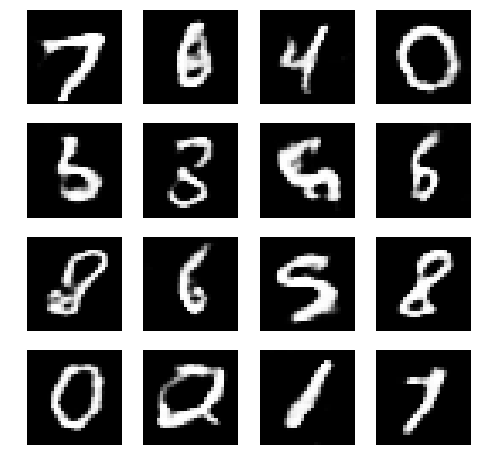

Wall time: 15min 15s


In [21]:
%%time
train(train_dataset, num_epochs)

In [22]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

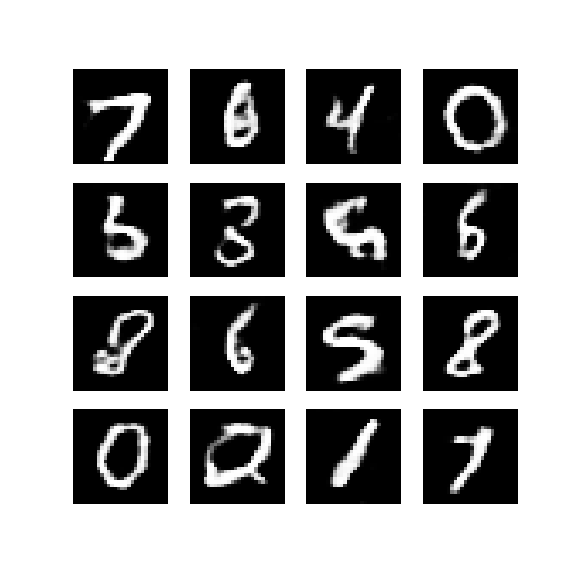

In [23]:
display_image(num_epochs)

## Creating a GIF

In [24]:
with imageio.get_writer('dcgan3.gif', mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
    
# this is a hack to display the gif inside the notebook
#os.system('cp dcgan.gif dcgan.gif.png')

In [25]:
#display.Image(filename="dcgan.gif.png")